In [310]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm

%matplotlib inline
sns.set()

df_confirmed = pd.read_csv(
    '../../corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv',
                sep=',',encoding='ISO8859-1')
df_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,43,43,43,47,48,50,50,50,53,59
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,274,293,331,360,420,461,502,511,581,639
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,108,110,110,117,130,138,150,150,160,178
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,29,36,50,50,83,93,99,117,129,149


In [311]:
country_list = sorted(df_confirmed['Country/Region'].unique())
#country_list


In [312]:
countries = df_confirmed.groupby('Country/Region')
country_increase = pd.DataFrame(countries.sum().iloc[:,-1] - countries.sum().iloc[:,-2],columns=['increase'])
country_increase['today'] = countries.sum().iloc[:,-1]
country_increase['previous_day'] = countries.sum().iloc[:,-2]
country_increase['factor'] = countries.sum().iloc[:,-1] / countries.sum().iloc[:,-2]
country_increase['factor'] = country_increase['factor'].replace(np.inf,np.nan)
country_increase.sort_values(by='increase',ascending=False,inplace=True)
country_increase = country_increase[['previous_day','today','increase','factor']]
country_increase.head(10)
                                                                    

,previous_day,today,increase,factor
Country/Region,,,,
Italy,10149,12462,2313,1.227904
Iran,8042,9000,958,1.119125
US,1665,2384,719,1.431832
Spain,1695,2277,582,1.343363
France,1787,2284,497,1.278120
Germany,1457,1908,451,1.309540
"Korea, South",7513,7755,242,1.032211
Qatar,24,262,238,10.916667
Norway,400,598,198,1.495000


In [313]:
country_increase[['previous_day','today','increase']].sum()

previous_day    119298
today           126968
increase          7670
dtype: int64

In [314]:
country_increase.describe()

,previous_day,today,increase,factor
count,114.000000,114.000000,114.000000,107.000000
mean,1046.473684,1113.754386,67.280702,1.587720
std,7674.174177,7715.058032,254.846249,1.539850
min,0.000000,1.000000,0.000000,1.000000
25%,3.000000,5.000000,0.250000,1.000000
50%,12.500000,16.500000,3.000000,1.225806
75%,66.500000,73.500000,18.000000,1.444444
max,80887.000000,80921.000000,2313.000000,11.000000


/usr/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecatio

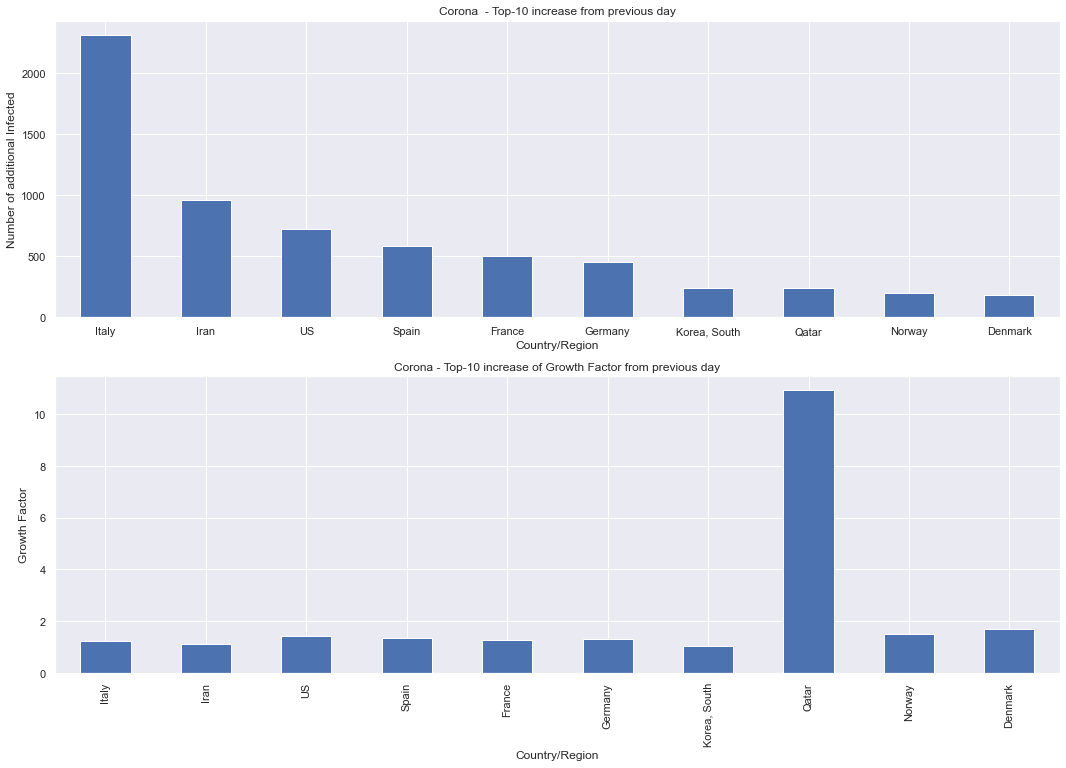

In [315]:
# pandas plot generates a warning about depreciated feature. Nothing to do bout it, it's pandas internal
plt.figure(figsize=(18,12))
plt.subplot(211)
plt.title('Corona  - Top-10 increase from previous day')
plt.ylabel('Number of additional Infected')
country_increase['increase'][:10].plot(kind='bar')
plt.xticks(rotation=0)
plt.subplot(212)
plt.title('Corona - Top-10 increase of Growth Factor from previous day')
plt.ylabel('Growth Factor')
country_increase['factor'][:10].plot(kind='bar')
plt.savefig('top_10_daily_growth.jpg',format='jpg')

In [316]:
#### SELECT COUNTRY OF INTEREST
#### for other countries, replace the country name in the line below ###
####

country_of_interest = 'Italy'

####
####

us = countries.get_group(country_of_interest)
us.head()

,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20
16,NaN,43.0,12.0,0,0,0,0,0,0,0,...,2036,2502,3089,3858,4636,5883,7375,9172,10149,12462


In [317]:
us_count = us.iloc[:,4:].sum()
us_count.index = pd.to_datetime(us_count.index)
us_count = pd.DataFrame(us_count,columns=['confirmed'])
us_count['factor'] = us_count['confirmed'] / us_count['confirmed'].shift()
us_count['factor'].replace(np.inf,np.nan)
us_count['day'] = np.arange(1,len(us_count) + 1)
us_count = us_count.loc[us_count['confirmed'] > 0]
us_count['factor'] = us_count['factor'].replace(np.inf,np.nan)
us_count.tail(60)

,confirmed,factor,day
2020-01-31,2,NaN,9
2020-02-01,2,1.000000,10
2020-02-02,2,1.000000,11
2020-02-03,2,1.000000,12
2020-02-04,2,1.000000,13
2020-02-05,2,1.000000,14
2020-02-06,2,1.000000,15
2020-02-07,3,1.500000,16
2020-02-08,3,1.000000,17
2020-02-09,3,1.000000,18


In [318]:
us_count.describe()


,confirmed,factor,day
count,41.000000,40.000000,41.000000
mean,1629.853659,1.371185,29.000000
std,3100.763733,0.950421,11.979149
min,2.000000,1.000000,9.000000
25%,3.000000,1.000000,19.000000
50%,3.000000,1.154089,29.000000
75%,1694.000000,1.291634,39.000000
max,12462.000000,6.666667,49.000000


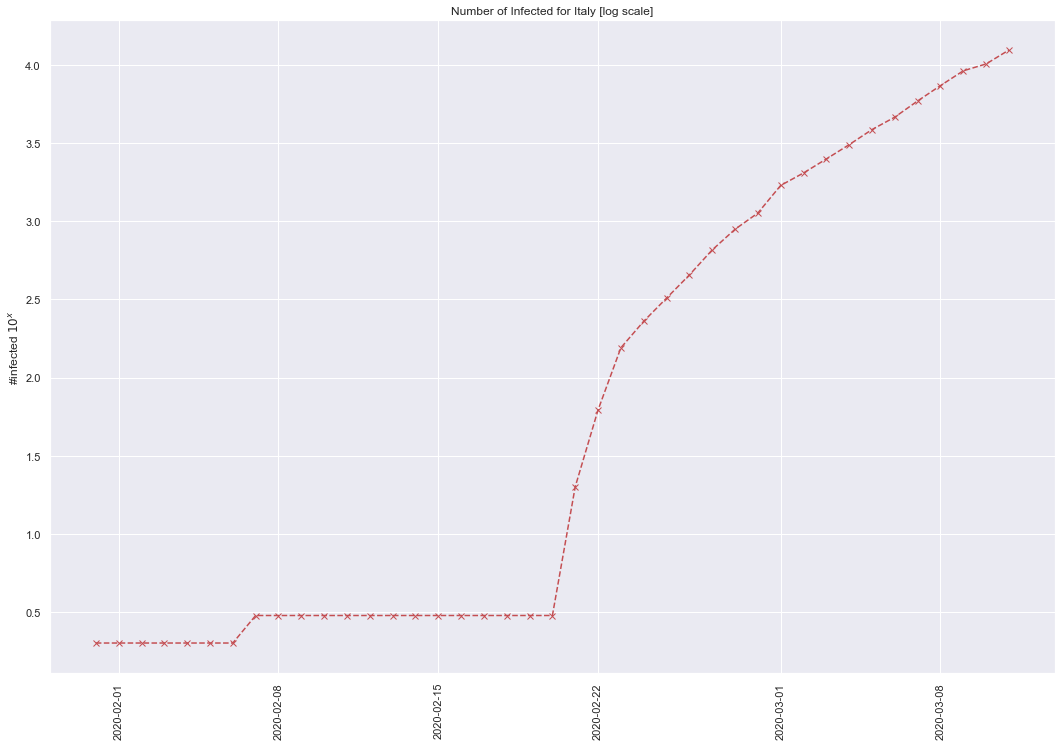

In [319]:
plt.figure(figsize=(18,12))
plt.title('Number of Infected for ' + country_of_interest + ' [log scale]')
plt.plot(np.log10(us_count['confirmed']),'x--',color='r')
plt.ylabel(r'#infected $10^x$')
plt.xticks(rotation=90)
plt.savefig('nr_infected_log_' + country_of_interest + '.jpg',format='jpg')

In [320]:
factor_mean = us_count['factor'].mean()
factor_std = us_count['factor'].std()
day_mean = us_count['day'].mean()
day_std = us_count['day'].std()

def standardize(x):
    return (x - x.mean()) / x.std()

us_count['day'] = standardize(us_count['day'])
us_count['factor'] = standardize(us_count['factor'])
us_count.tail()

,confirmed,factor,day
2020-03-07,5883,-0.107534,1.335654
2020-03-08,7375,-0.123706,1.419133
2020-03-09,9172,-0.134176,1.502611
2020-03-10,10149,-0.278471,1.586089
2020-03-11,12462,-0.150755,1.669568


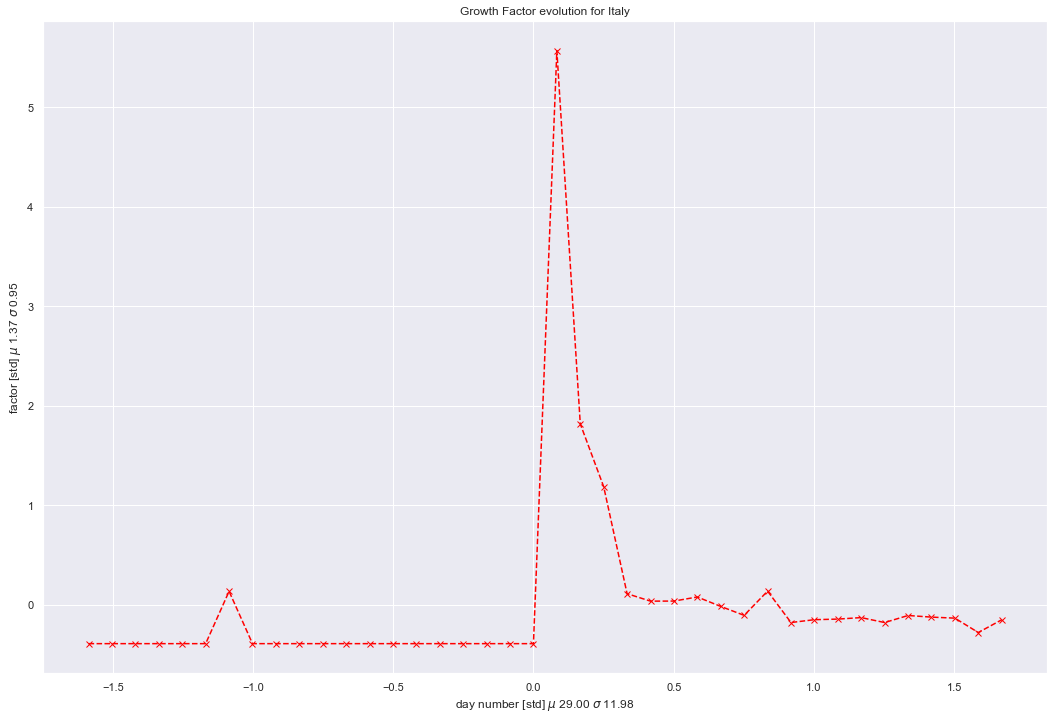

In [321]:
plt.figure(figsize=(18,12))
plt.title('Growth Factor evolution for ' + country_of_interest)
plt.plot(us_count['day'],us_count['factor'],'x--',color='red')
_=plt.xlabel(r'day number [std] $\mu$ {:.2f} $\sigma$ {:.2f}'.format(day_mean,day_std))
_=plt.ylabel(r'factor [std] $\mu$ {:.2f} $\sigma$ {:.2f}'.format(factor_mean,factor_std))
plt.savefig('growth_factor_evolution_' + country_of_interest +'.jpg',format='jpg')

alpha mean 0.00 beta mean 0.00


Text(0.5, 1.0, 'lines simulated from priors')

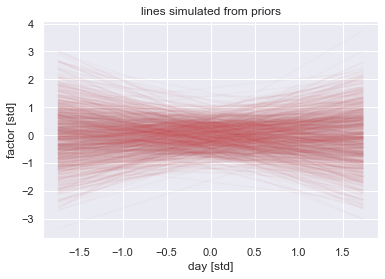

In [322]:
#FIGURE OUT PRIORS by random sampling
# purpose: to see that the priors, before seeing data, produce
# resonable regression lines, i.e. the lines should not extend beyond 3 standard deviations 
# at the y-axis.

def sim_linreq_mu(x,alpha,beta):
    return x * alpha + beta

#SIMULATE priors 
#HYPOTHESIS by looking at graph: 
alpha_mu = 0 #HYPOTHESIS: intercept at 0
alpha_sigma = 0.5
beta_mu = 0 #HYPOTHESIS: slope 0
beta_sigma = 0.5

size = 10000
# simulate priors based on params above
alpha = pm.rnormal(mu = alpha_mu,tau = 1 / alpha_sigma ** 2,size=size)
beta =  pm.rnormal(mu = beta_mu, tau = 1 / beta_sigma ** 2,size=size)

print ('alpha mean {:.2f} beta mean {:.2f}'.format(alpha.mean(),beta.mean()))

# sample simulated priors
nr_rows = 1000
alphas = np.random.choice(alpha,replace=True,size=nr_rows)
betas = np.random.choice(beta,replace=True,size=nr_rows)

# build simulated regression lines
X = np.linspace(min(us_count['day']),max(us_count['day']),nr_rows)
X = standardize(X)
lines = [X[i] * betas + alphas for i in range(len(X))]

_=plt.plot(X,lines,color='r',alpha=0.03)
plt.ylabel('factor [std]')
plt.xlabel('day [std]')
plt.title('lines simulated from priors')


In [323]:
#REGRESSION
alpha = pm.Normal('alpha',mu=alpha_mu,tau = 1 / alpha_sigma ** 2)
beta = pm.Normal('beta',mu=beta_mu, tau = 1/ beta_sigma ** 2)
sigma = pm.Uniform('sigma',lower=0,upper=10)

us_count.dropna(inplace = True) # pymc doesnt like them
x = us_count['day']

@pm.deterministic()
def linreq_mu(x=x,alpha=alpha,beta=beta):
    return x * beta + alpha

likelihood = pm.Normal('likelihood',
                     mu=linreq_mu,
                     tau= 1 / sigma ** 2,
                     observed = True,
                      value=us_count['factor'])

model = pm.Model([alpha,beta,sigma,linreq_mu,likelihood])
map_ = pm.MAP(model)
map_.fit()

mcmc = pm.MCMC(model)
mcmc.sample(10000,5000,2)

alpha_post = mcmc.trace('alpha')[:]
beta_post = mcmc.trace('beta')[:]
sigma_post = mcmc.trace('sigma')[:]
linreq_mu_post = mcmc.trace('linreq_mu')[:,0]

result = pd.DataFrame({'alpha_post':alpha_post,
                       'beta_post':beta_post,
                       'sigma_post':sigma_post,
                       'linreq_mu_post':linreq_mu_post})

result.describe()


 [-----------------100%-----------------] 10000 of 10000 complete in 10.2 sec

,alpha_post,beta_post,sigma_post,linreq_mu_post
count,2500.000000,2500.000000,2500.000000,2500.000000
mean,-0.009084,0.108515,1.038803,-0.181198
std,0.156772,0.158929,0.123276,0.300694
min,-0.560054,-0.494893,0.697701,-1.235630
25%,-0.109527,0.002970,0.952744,-0.394768
50%,-0.012312,0.109117,1.026145,-0.174458
75%,0.094446,0.213135,1.105111,0.022207
max,0.612632,0.568250,1.630658,0.830826


In [324]:
# LEAST SQUARES REGRESSION for comparison
slope,intercept,_,_,_ = sps.linregress(x,us_count['factor'])

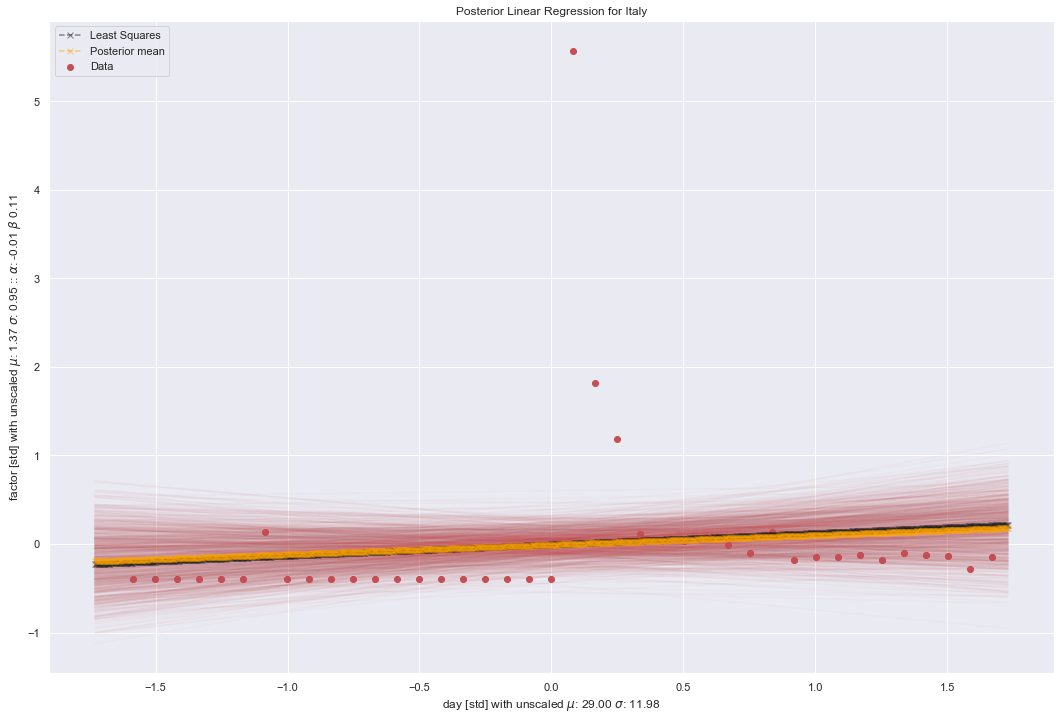

In [325]:
#PLOT POSTERIOR
alphas = np.random.choice(result['alpha_post'],replace=True,size=nr_rows)
betas = np.random.choice(result['beta_post'],replace=True,size=nr_rows)
sigmas = np.random.choice(result['sigma_post'],replace=True,size=nr_rows)

mus = np.array([X[i] * betas + alphas for i in range(len(X))])

lsq_mus = np.array([X[i] * slope + intercept for i in range(len(X))])

plt.figure(figsize=(18,12))
plt.title('Posterior Linear Regression for ' + country_of_interest)
plt.plot(X,mus,color='r',alpha=0.03)
plt.plot(X,lsq_mus,'x--',color='k',label='Least Squares',alpha=0.5)
plt.plot(X,np.array([X[i] * beta_post.mean() + alpha_post.mean() for i in range(len(X))]),
        'x--',color='orange',label='Posterior mean',alpha=0.5)

plt.scatter(us_count['day'],us_count['factor'],color='r',label='Data')

xlabel = r'day [std] with unscaled $\mu$: {:.2f} $\sigma$: {:.2f}'.format(
    day_mean,
    day_std)

ylabel = r'factor [std] with unscaled $\mu$: {:.2f} $\sigma$: {:.2f} :: $\alpha$: {:.2f} $\beta$ {:.2f}'.format(
    factor_mean,
    factor_std,
    alpha_post.mean(),
    beta_post.mean())

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend(loc='upper left')
plt.savefig('linear_regression_' + country_of_interest +'.jpg',format='jpg')




